<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Funcionales en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Homework 03 - Diffusion Maps</div><br>
    <div style="font-size: large">María Barroso y Gloria del Valle</div><br></div><hr> 
</div>

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [1]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Exercise"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used.

In [3]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.datasets import make_blobs, make_swiss_roll, make_s_curve

from mpl_toolkits.mplot3d import Axes3D

Axes3D

matplotlib.rc("figure", figsize=(15, 5))

seed = 123
my_cmap = plt.cm.Spectral

# Introduction

This practical assignment is about implementing the manifold learning method **Diffusion Maps**, following the *scikit-learn* template for manifold learning algorithms.

We will design two main functions: one for training the algorithm, obtaining the affinity matrix and the embedded coordinates, and a second one for extending these coordinates for new patterns.

# Requirements

The objective of this assignment is to complete the class DM sketched below, which should contain at least the following methods.

`__init__(self, sigma, n_components, step=1, alpha=1)`

* This is the construction method for the class, with the following parameters:
    * `sigma`: Kernel parameter for the Gaussian kernel.
    * `n_components`: dimension of the embedding.
    * `step`: step in the Markov Chain.
    * `alpha`: density influence. It should take a value in `[0,1]`.
* This method just store the parameters in the fields of the class, to be used when needed.

`fit(self, X, y=None)`

* This is the training method, the one that performs the Diffusion Maps algorithm. 

* This method should store the affinity matrix and also the eigenvectors to computed the transformation.

`fit_transform(self, X, y=None)`

* This method returns the embedding coordinates for the training data.
* It should also store the affinity matrix and the coordinates needed to compute the transformation (for example over new, unseen patterns).

`transform(self, X)`

* This method will obtain approximated coordinates for new, unseen data points. 
* It uses for this purpose the Nyström Formula.

## Some recommendations

* It should allow to fix all the DM possibilities (different steps, density normalization...). To allow a change in the kernel function could be also a nice idea.
* Implement all the auxiliary functions that you may need, for example, for deciding the best parameter values in each case.
* It could be a nice idea to offer a deterministic output, that do not depend on the sign of the eigenvectors.

# Implementation

<div class="qst">

* Complete the `DM` class below, satisfying the described requirements.

</div>

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel, pairwise_distances
from sklearn.utils.extmath import svd_flip
from scipy.spatial import distance

In [5]:
class DM(TransformerMixin, BaseEstimator):
    """
    Diffusion Maps.
    """

    def __init__(
        self,
        n_components: int = 2,
        kernel_type: str = "rbf",
        sigma: (str, float) = "percentil",
        step: int = 0,
        alpha: float = 0.0,
        percentil: float = 50,
    ) -> None:
        """
        Parameters
        ----------
        n_components:
            Embedded space dimension.
        kernel_type:
            kernel type to compute the affinity matrix. Can be 'rbf' or 'laplacian' kernel.
        sigma:
            Sigma parameter of rbf or laplacian kernel.
        step:
            Number of steps to advance in the Markov chain.
        alpha:
            Normalization parameter to control the density influence.
        percentil:
            Percentile vale to calculate sigma used when self.sigma == 'percentil'.
        """

        self.n_components = n_components
        self.kernel_type = kernel_type
        self.sigma = sigma
        self.step = step
        self.alpha = alpha
        self.percentil = percentil

    def compute_sigma(self):
        """Compute sigma value for the affinity matrix distinguishing each possible method."""
        if self.sigma == "median":
            self.sigma_ = np.percentile(pairwise_distances(self.X), 50)
        elif self.sigma == "maximum":
            self.sigma_ = np.percentile(pairwise_distances(self.X), 100)
        elif self.sigma == "auto":
            self.sigma_ = np.sqrt(
                self.X.shape[1] / 2
            )  # like SVM sklearn gamma = 1/n_features
        elif self.sigma == "percentil":
            self.sigma_ = np.percentile(pairwise_distances(self.X), self.percentil)
        elif isinstance(self.sigma, float) and self.sigma > 0.0:
            self.sigma_ = self.sigma
        else:
            raise ValueError(
                "Please, enter a correct sigma method: 'percentil', 'maximun', 'auto' or a direct positive sigma value"
            )

    def compute_affinity_matrix(
        self, X: np.ndarray, Y: np.ndarray = None
    ) -> np.ndarray:
        """
        Compute affinity matrix for X data.
        Parameters
        ----------
        X:
            Data matrix
        y:
            Data matrix [Optional]
        Returns
        -------
        Kernel matrix
        """

        if not hasattr(self, "sigma_"):
            self.compute_sigma()

        if self.kernel_type == "rbf":
            return rbf_kernel(X, Y, gamma=1 / (2 * self.sigma_**2))
        if self.kernel_type == "laplacian":
            return laplacian_kernel(X, Y, gamma=1 / (2 * self.sigma_**2))
        else:
            raise ValueError(
                "Please, enter a correct kernel method: 'rbf' or 'laplacian'."
            )

    def fit(self, X: np.ndarray, y: np.ndarray = None):
        """
        Compute the embedding vectors for data X
        Parameters
        ----------
        X :
            Array-like of shape [n_samples, n_features]
            training set.
        y :
            Ignored
        Returns
        -------
        self :
            Returns an instance of self.
        """

        # Store X for Nystrom approximation
        self.X = X

        # Kernel definition with affinity matrix
        K = self.compute_affinity_matrix(X)

        # Compute distance matrix with density
        D = np.sum(K, axis=1) ** self.alpha

        # Compute density normalization
        K_alpha = K / D / D.T

        # Compute distance matrix with K normalized
        D_alpha = np.sum(K_alpha, axis=1).reshape(-1, 1)

        # Compute stationary distribution
        pi = (D_alpha / np.sum(D_alpha)).reshape(-1, 1)

        # P reduced to orthonormal basis by diagonal matrix
            # We consider its conjugated matrix A
        D_sqrt = np.sqrt(D_alpha)
        A = K_alpha / D_sqrt / D_sqrt.T

        # Obtain the SVD decomposition
        U, s, V = np.linalg.svd(A, full_matrices=True)

        # Sign correction
        U, _ = svd_flip(U, V)

        # Compute final eigenvector of P and eigenvalues
        eigenvectors = U / np.sqrt(pi)
        eigenvalues = s**2

        # Discard autovalue 1
        self.eigenvalues = eigenvalues[1 : self.n_components + 1]
        self.eigenvectors = eigenvectors[:, 1 : self.n_components + 1]

        return self

    def fit_transform(self, X: np.ndarray, y: np.ndarray = None) -> np.ndarray:
        """
        Compute the embedding vectors for data X and transform X.
        Parameters
        ----------
        X :
            Array-like of shape [n_samples, n_features]
            training set.
        y :
            Ignored
        Returns
        -------
        X_red :
            Array-like, shape (n_samples, n_components)
        """

        # Fit training set
        self.fit(X)

        # Compute the embedding
        self.embedding = (self.eigenvalues**self.step) * self.eigenvectors

        return self.embedding

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Transform X.
        This function is implemented using the Nyström formula.
        Parameters
        ----------
        X :
            Array-like, shape (n_samples, n_features).
        Returns
        -------
        X_red :
            Array-like, shape (n_samples, n_components)
        """

        # Compute Kernel for the new X data and the X stored before
        K = self.compute_affinity_matrix(X, self.X)

        # Compute Distance Diffusion
        D = (K.sum(axis=1) ** self.alpha).reshape(-1, 1)

        # Transition Probability Matrix definition
            # Probability of arriving from i to j in one step
        P = K / D

        # Compute nystrom features
        X_red = (P @ self.eigenvectors) / self.eigenvalues

        return X_red

# Experiments with DM

<div class="qst">

* Obtain some good embedded coordinates for the three training datasets specified below.
    
* Extend its coordinates for the new points.
    
</div>

Definimos un objeto StandardScaler para estandarizar todos los datos que utilizaremos a lo largo del notebook. Así estarán centrados y escalados a 1 y será posible realizar el embedding utilizando Diffusion Maps.

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

## Dataset 1: two blobs

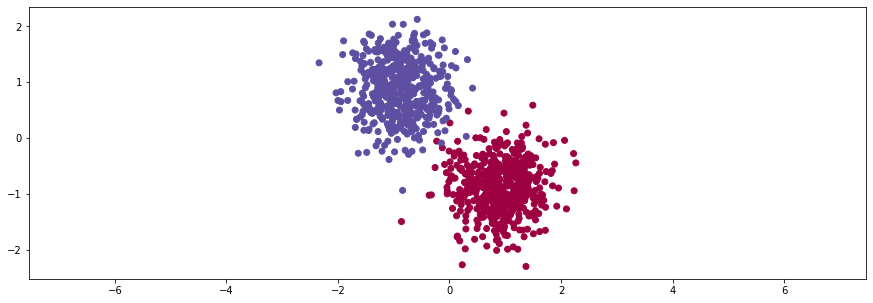

In [7]:
N = 1000

X, y = make_blobs(
    n_samples=N, n_features=50, centers=2, cluster_std=3.0, random_state=seed
)
X = scaler.fit_transform(X)

y[y != 1] = -1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
plt.axis("equal")
plt.show()

N_new = 100
X_new, y_new = make_blobs(
    n_samples=N_new, n_features=50, centers=2, cluster_std=3.0, random_state=seed + 1
)
X_new = scaler.transform(X_new)

Se representan las nuevas coordenadas del embedding para $T=\alpha=0$ con un núcleo gaussiano variando el parámetro $\sigma$.

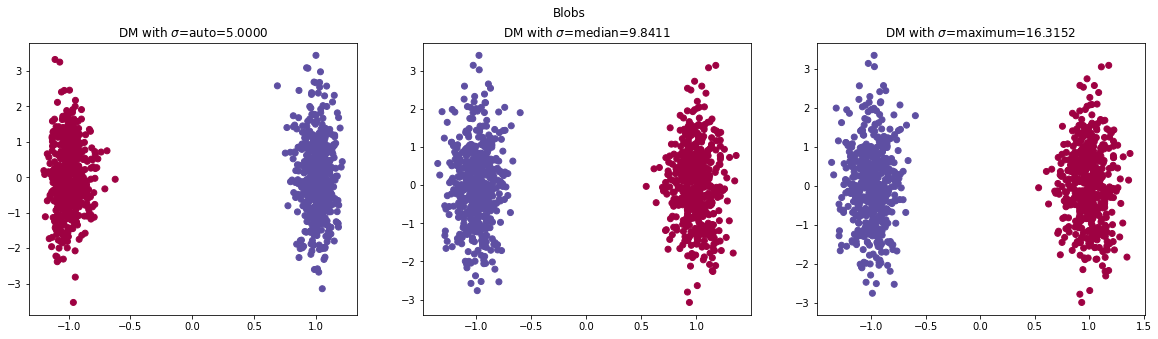

In [8]:
sigma_parameters = ["auto", "median", "maximum"]
dm_alpha = [DM(sigma=sigma) for sigma in sigma_parameters]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("Blobs")
for i, dm in enumerate(dm_alpha):
    X_red = dm.fit_transform(X)
    axes[i].scatter(X_red[:, 0], X_red[:, 1], c=y, cmap=my_cmap)
    axes[i].set_title(
        r"DM with $\sigma$={0}={1:.4f}".format(sigma_parameters[i], dm.sigma_)
    )

No observamos ninguna diferencia notable entre los embedding, así elegimos una representación que utilice la mediana.

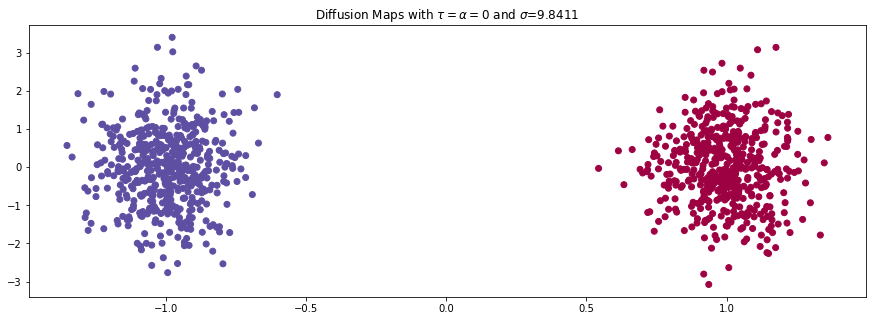

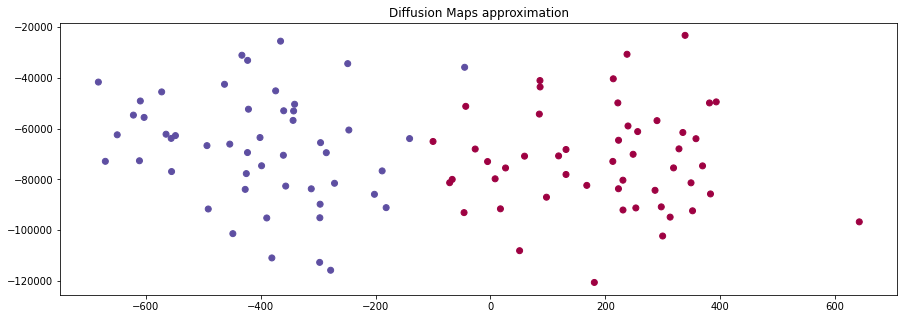

In [9]:
dm = DM(sigma="median")
X_red = dm.fit_transform(X)

plt.scatter(X_red[:, 0], X_red[:, 1], c=y, cmap=my_cmap)
plt.title(r"Diffusion Maps with $\tau=\alpha=0$ and $\sigma$={0:.4f}".format(dm.sigma_))
plt.show()

X_red_new = dm.transform(X_new)

plt.scatter(X_red_new[:, 0], X_red_new[:, 1], c=y_new, cmap=my_cmap)
plt.title(r"Diffusion Maps approximation")
plt.show()

Observamos en la primera figura el embedding obtenido para los datos de entrenamiento. Vemos que las clases son linealmente separables y encontramos un margen de separación bastante grande.

Para los nuevos datos las clases no son linealmente separables. Si se utiliza un margen muy estrecho, vemos que uno de los puntos azules pertenecería a la clase roja. Sin embargo, podemos concluir que se trata de un buen embedding para datos no observados ya que la separación lineal es casi perfecta. 

## Dataset 2: the swiss roll

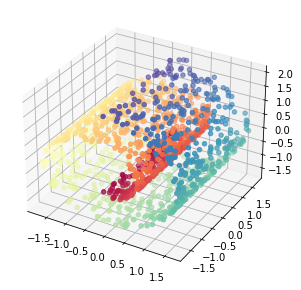

In [10]:
N = 1500
X, color = make_swiss_roll(n_samples=N, random_state=seed)
X = scaler.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=my_cmap)
plt.show()

N_new = 100
X_new, color_new = make_swiss_roll(n_samples=N_new, random_state=seed + 1)
X_new = scaler.transform(X_new)

En primer lugar, comprobaremos que los embedding obtenidos por nuestra clase implementada se corresponden con los mismos que devuelve  SpectralEmbedding cuando $T=\alpha=0$ para el núcleo gaussiano.

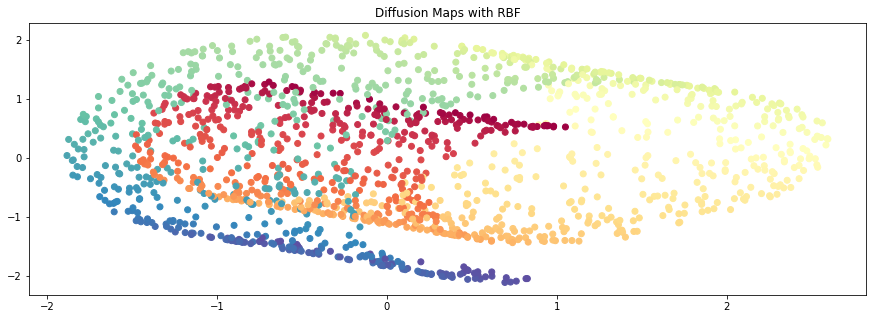

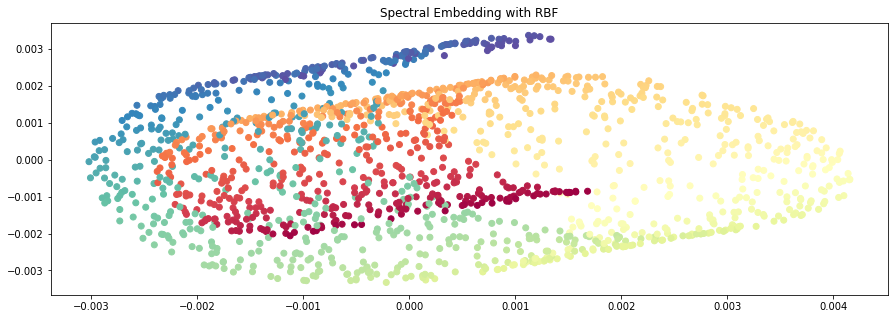

In [11]:
from sklearn.manifold import SpectralEmbedding

dm = DM(sigma=1.0)
X_red = dm.fit_transform(X)

plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.title(r"Diffusion Maps with RBF")
plt.show()

se = SpectralEmbedding(affinity="rbf", gamma=0.5)
X_red_sk = se.fit_transform(X)

plt.scatter(X_red_sk[:, 0], X_red_sk[:, 1], c=color, cmap=my_cmap)
plt.title("Spectral Embedding with RBF")
plt.show()

Vemos que coinciden, salvo por el signo y la escala.

A continuación, se representa el embedding de Diffusion Maps para $T=\alpha=0$ con un núcleo gaussiano variando el parámetro $\sigma$.

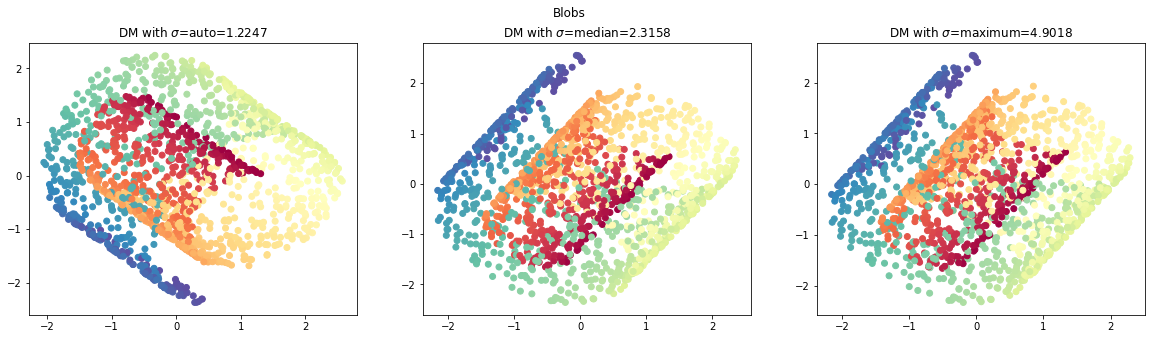

In [12]:
sigma_parameters = ["auto", "median", "maximum"]
dm_sigma = [DM(sigma=sigma) for sigma in sigma_parameters]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("Blobs")
for i, dm in enumerate(dm_sigma):
    X_red = dm.fit_transform(X)
    axes[i].scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
    axes[i].set_title(
        r"DM with $\sigma$={0}={1:.4f}".format(sigma_parameters[i], dm.sigma_)
    )

No se obtienen buenos embedding debido a la elección del parámetro sigma. Esto se debe a que el parámetro $\sigma$ es demasiado grande y estamos teniendo en cuenta la información de vecinos pertenecientes a otras clases. En este conjunto de datos, la estructura geométrica es más complicada y necesitamos que el embedding utilice información muy local. 

Por ese motivo, centraremos la elección de $\sigma$ variando el percentil seleccionado para distintos parámetros de densidad $\alpha=\{0.0, 0.3, 0.5\}$.

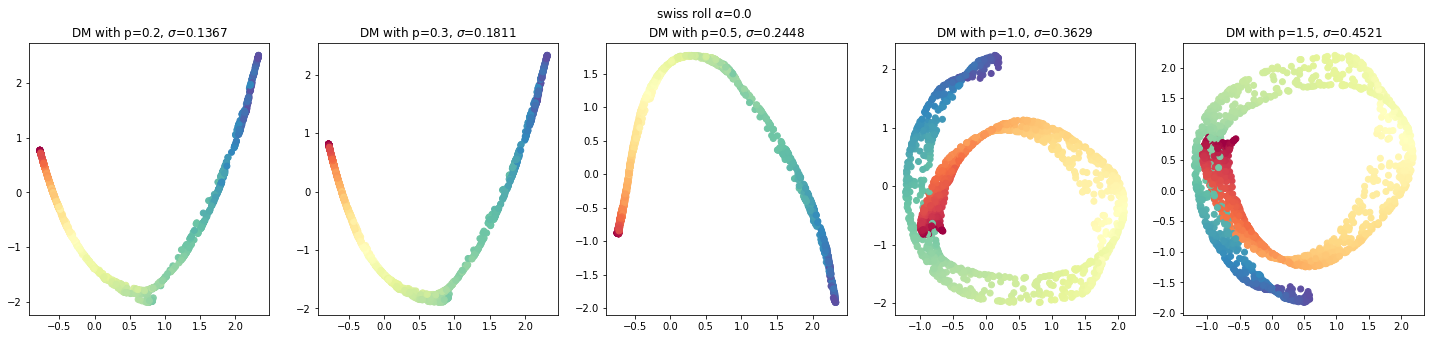

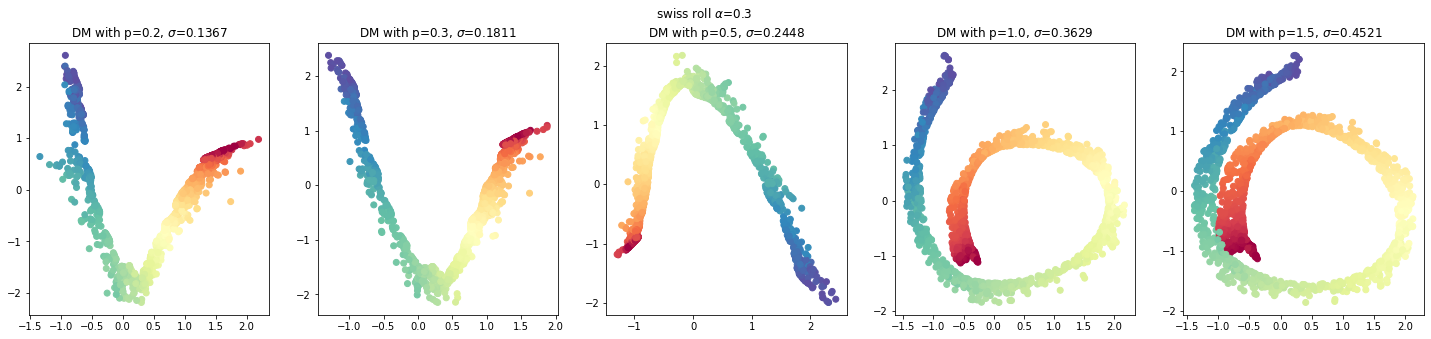

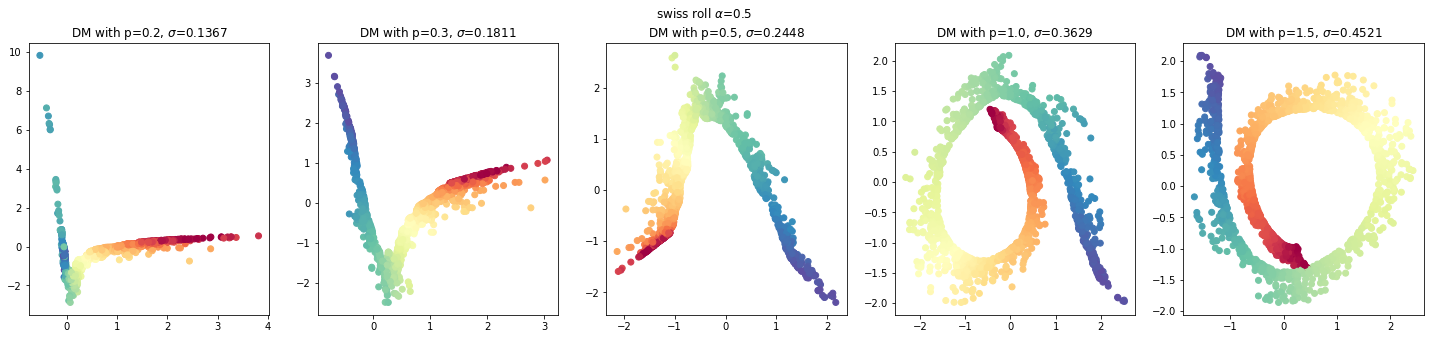

In [13]:
alpha_parameters = [0.0, 0.3, 0.5]
percentil_parameters = [0.2, 0.3, 0.5, 1.0, 1.5]

for alpha in alpha_parameters:
    dm_percentil = [
        DM(percentil=percentil, alpha=alpha) for percentil in percentil_parameters
    ]

    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    fig.suptitle(r"swiss roll $\alpha$={0}".format(alpha))
    for i, dm in enumerate(dm_percentil):
        X_red = dm.fit_transform(X)
        axes[i].scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
        axes[i].set_title(
            r"DM with p={0}, $\sigma$={1:.4f}".format(
                percentil_parameters[i], dm.sigma_
            )
        )

Observando las distintas configuraciones representadas podemos concluir que la mejor representación de los datos, aunque sin conseguir desenrollar el swiss roll, se obtiene al utilizar
* {$\alpha$ = 0.5, $\sigma$ = 0.244 $\sim$ percentil = $0.5$}}


El resto de representación o bien agrupan todos los datos cerca de cero o bien no consiguen eliminar la estructura enrollada de los datos.

A continuación representaremos los embeddings obtenidos al utilizar el núcleo laplaciano realizando el mismo experimento.

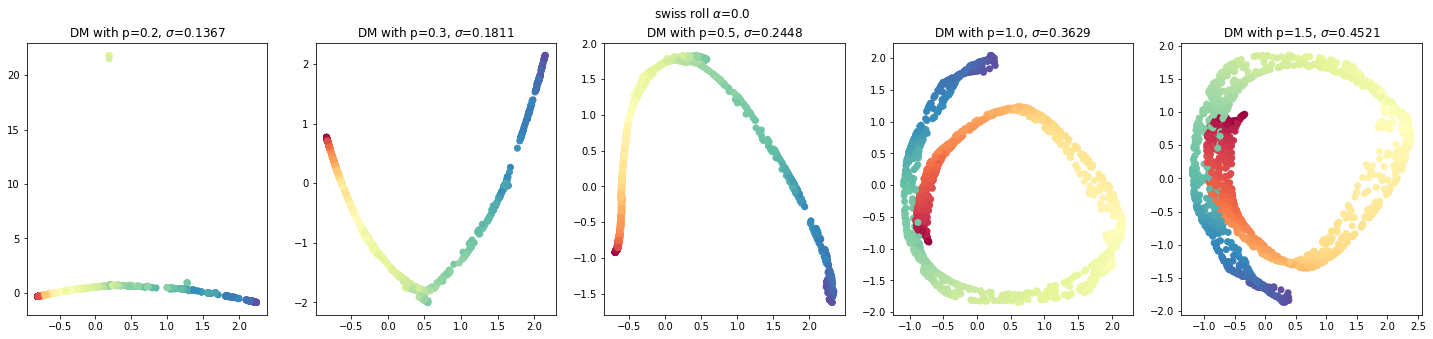

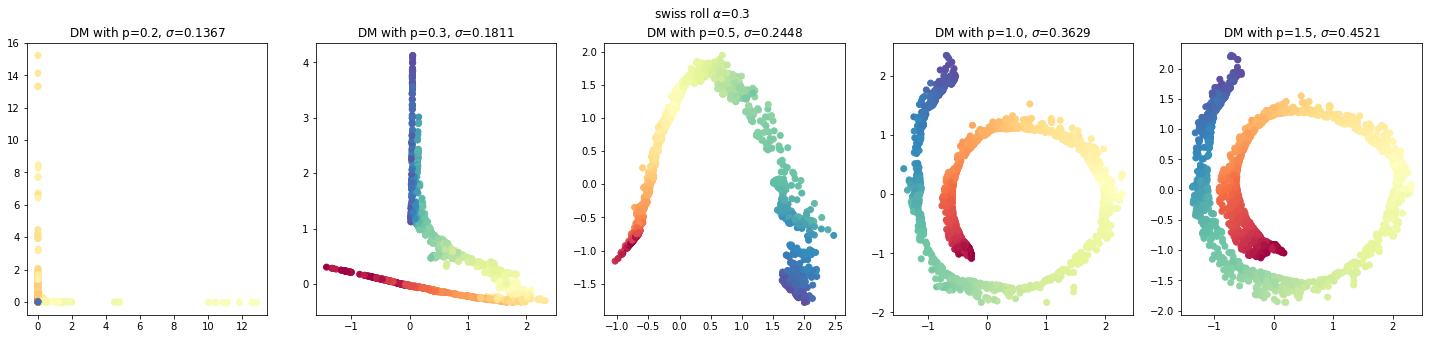

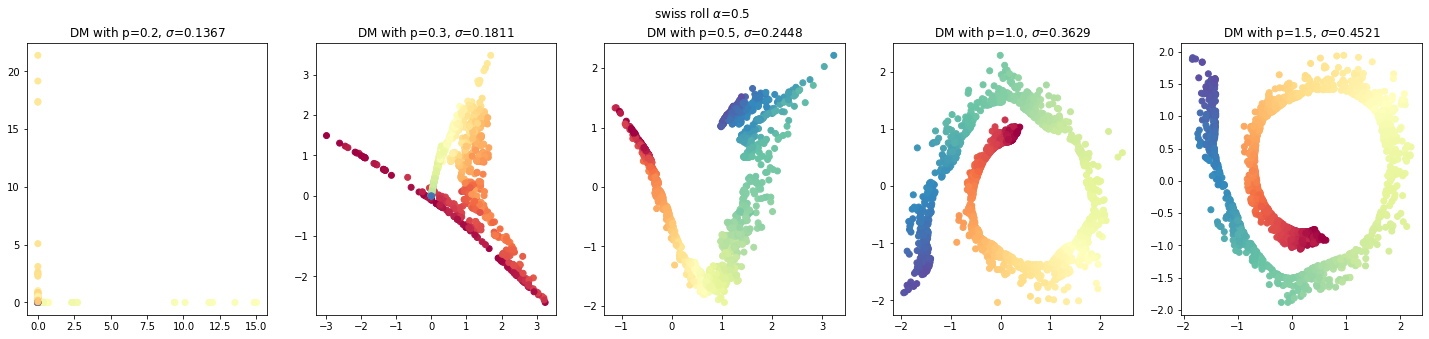

In [14]:
alpha_parameters = [0.0, 0.3, 0.5]
percentil_parameters = [0.2, 0.3, 0.5, 1.0, 1.5]

for alpha in alpha_parameters:
    dm_percentil = [
        DM(percentil=percentil, alpha=alpha, kernel_type="laplacian")
        for percentil in percentil_parameters
    ]

    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    fig.suptitle(r"swiss roll $\alpha$={0}".format(alpha))
    for i, dm in enumerate(dm_percentil):
        X_red = dm.fit_transform(X)
        axes[i].scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
        axes[i].set_title(
            r"DM with p={0}, $\sigma$={1:.4f}".format(
                percentil_parameters[i], dm.sigma_
            )
        )

Al utilizar el núcleo Laplaciano las conclusiones que podemos extraer cambian. En este caso, la mejor configuración que consigue desenrollar los datos se obtiene al utilizar $\alpha=0.0$ y $\sigma=0.1367$, seleccionado a partir del percentil 0.2. Es decir, que al utilizar un núcleo Laplaciano, utilizar información más local consigue mejores resultados.  


Sobre las dos mejores configuración de parámetros obtenidas

- {kernel gaussiano, $\alpha=0.5$ $\sim$ percentil = $0.5$}
- {kernel laplaciano, $\alpha=0.0$  $\sim$ percentil = $0.2$}

ilustraremos el embedding y la aproximación de Nystrom para nuevos datos. 

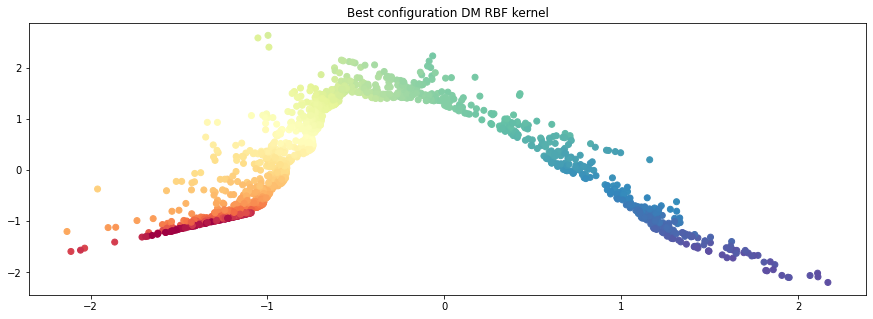

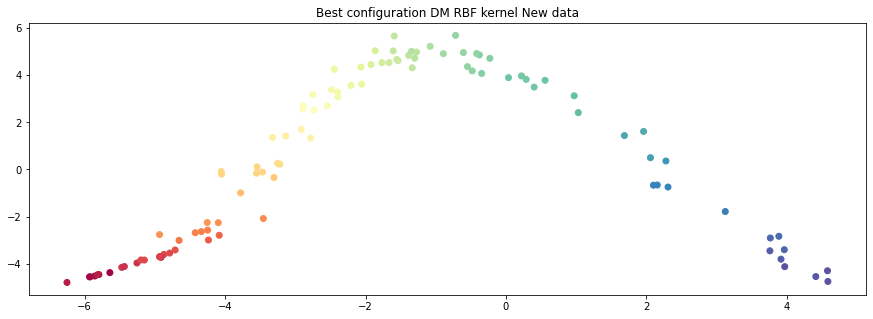

In [15]:
#### Best configuration RBF
dm = DM(percentil=0.5, alpha=0.5)
X_red = dm.fit_transform(X)

plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.title("Best configuration DM RBF kernel")
plt.show()

X_red_new = dm.transform(X_new)

plt.scatter(X_red_new[:, 0], X_red_new[:, 1], c=color_new, cmap=my_cmap)
plt.title(r"Best configuration DM RBF kernel New data")
plt.show()

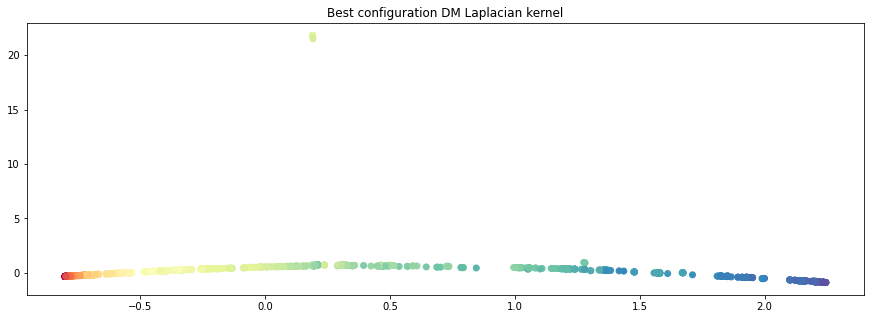

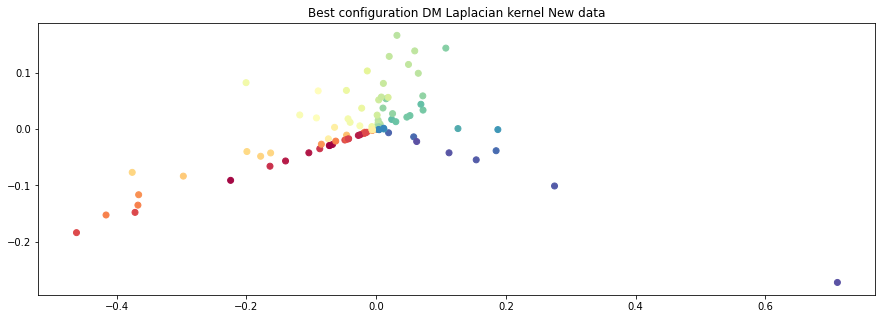

In [16]:
#### Best configuration laplacian
dm = DM(percentil=0.2, kernel_type="laplacian", alpha=0.0)
X_red = dm.fit_transform(X)

plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.title("Best configuration DM Laplacian kernel")
plt.show()

X_red_new = dm.transform(X_new)

plt.scatter(X_red_new[:, 0], X_red_new[:, 1], c=color_new, cmap=my_cmap)
plt.title(r"Best configuration DM Laplacian kernel New data")
plt.show()

Observamos que aunque la aproximación Laplaciana es mucho más exacta, no se comporta bien para datos no observados. En cambio, utilizando el núcleo gaussiano se obtiene una buena representación para datos no observados.

## Dataset 3: the S curve

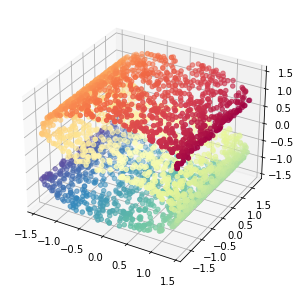

In [17]:
N = 3000
X, color = make_s_curve(N, random_state=seed)
X = scaler.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=my_cmap)
plt.show()

N_new = 100
X_new, color_new = make_s_curve(N_new, random_state=seed + 1)
X_new = scaler.transform(X_new)

En primer lugar, probaremos si se obtiene la misma representación que la obtenida por la clase SpectralEmbedding imeplementada en sklearn.

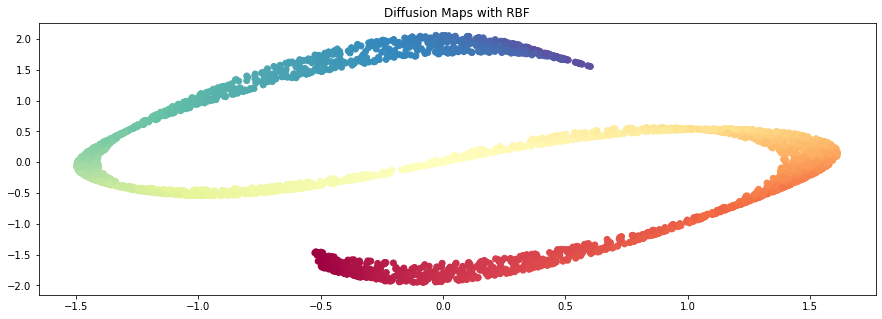

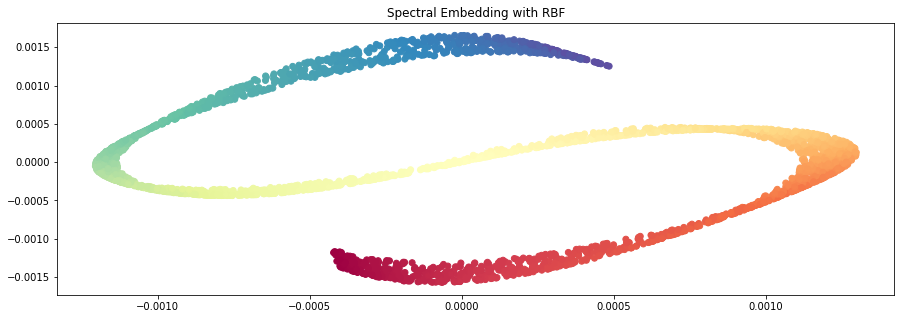

In [18]:
dm = DM(sigma=1.0)
X_red = dm.fit_transform(X)

plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.title(r"Diffusion Maps with RBF")
plt.show()

se = SpectralEmbedding(affinity="rbf", gamma=0.5)
X_red_sk = se.fit_transform(X)

plt.scatter(X_red_sk[:, 0], X_red_sk[:, 1], c=color, cmap=my_cmap)
plt.title("Spectral Embedding with RBF")
plt.show()

Después, al igual que hicimos con el conjunto de datos anterior, representamos el embedding para $T=0$ con un núcleo gaussiano variando el parámetro percentil en lugar de variando el parámetro sigma ya que interesa mantener la información local de los datos. Además, se prueba para 3 parámetros de densidad  $\alpha=\{0, 0.3,0.5\}$. 

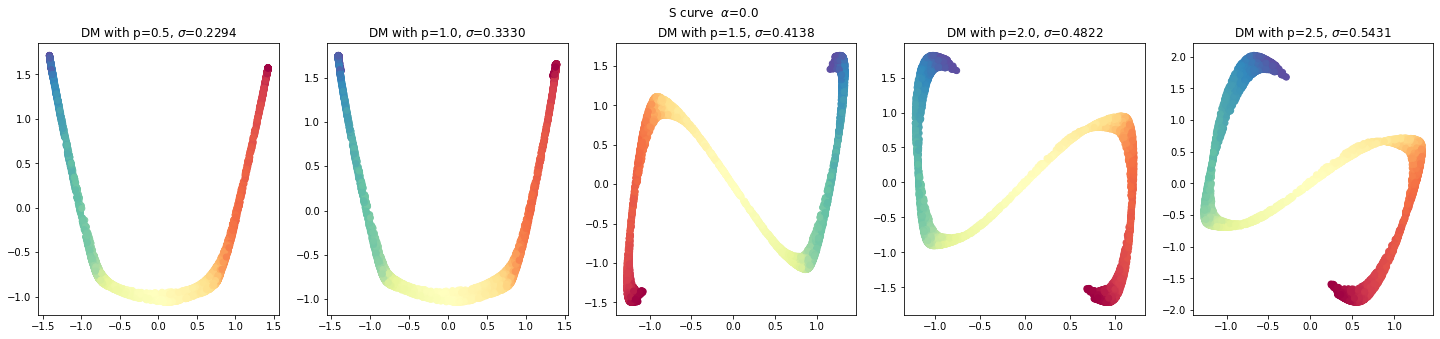

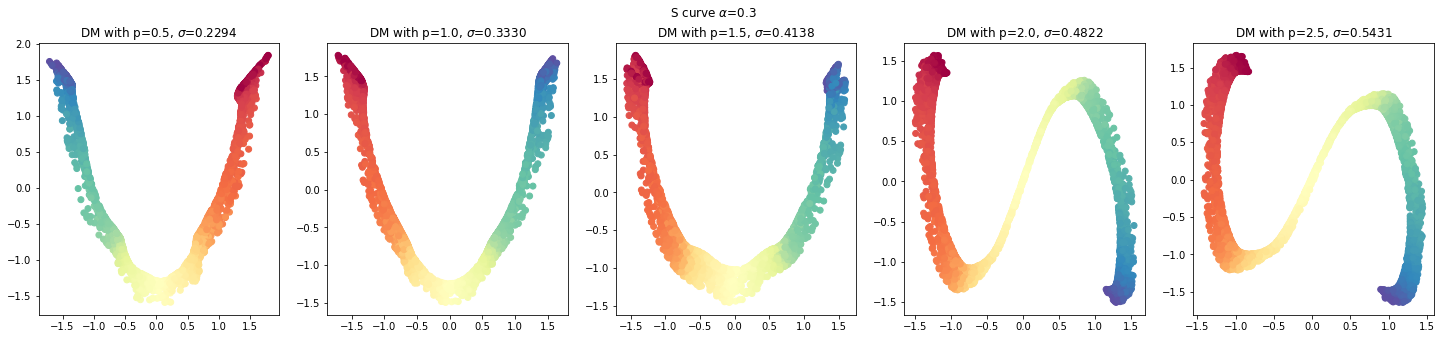

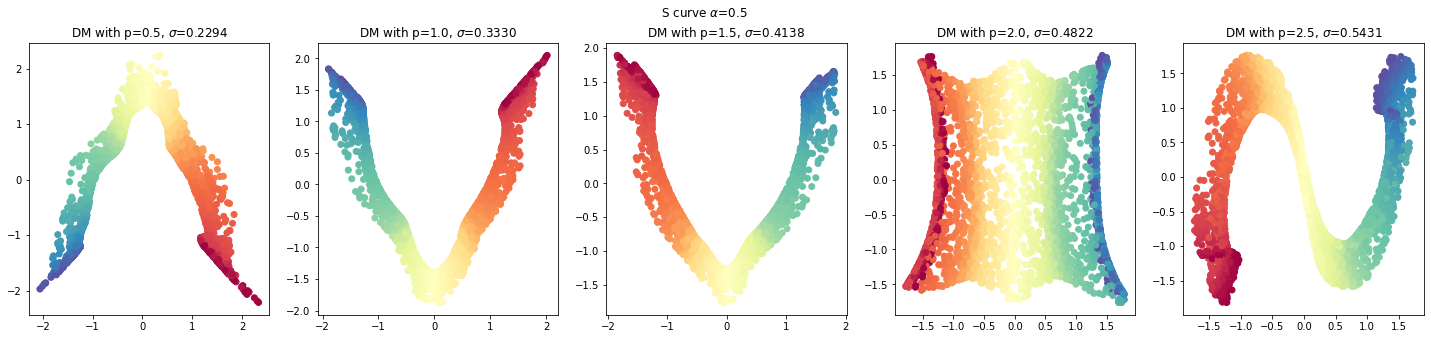

In [19]:
alpha_parameters = [0.0, 0.3, 0.5]
percentil_parameters = [0.5, 1.0, 1.5, 2.0, 2.5]

for alpha in alpha_parameters:
    dm_percentil = [
        DM(percentil=percentil, alpha=alpha) for percentil in percentil_parameters
    ]

    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    fig.suptitle(r"S curve  $\alpha$={0}".format(alpha))
    for i, dm in enumerate(dm_percentil):
        X_red = dm.fit_transform(X)
        axes[i].scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
        axes[i].set_title(
            r"DM with p={0}, $\sigma$={1:.4f}".format(
                percentil_parameters[i], dm.sigma_
            )
        )

Cuando $\alpha=0$, obtenemos representaciones en forma de 'U' y otras representaciones en las que se mantiene la estructura de 'S' de los datos. Cuando $\alpha=0.3$, ocurre lo mismo aunque los datos están más dispersos. En cambio, cuando $\alpha=0.5$, conseguimos desenrollar la 'S' al aumentar el tamaño de $\sigma$ a 0.48 y obtenemos una banda aplanada.

A continuación, realizaremos la misma exploración para el núcleo laplaciano.

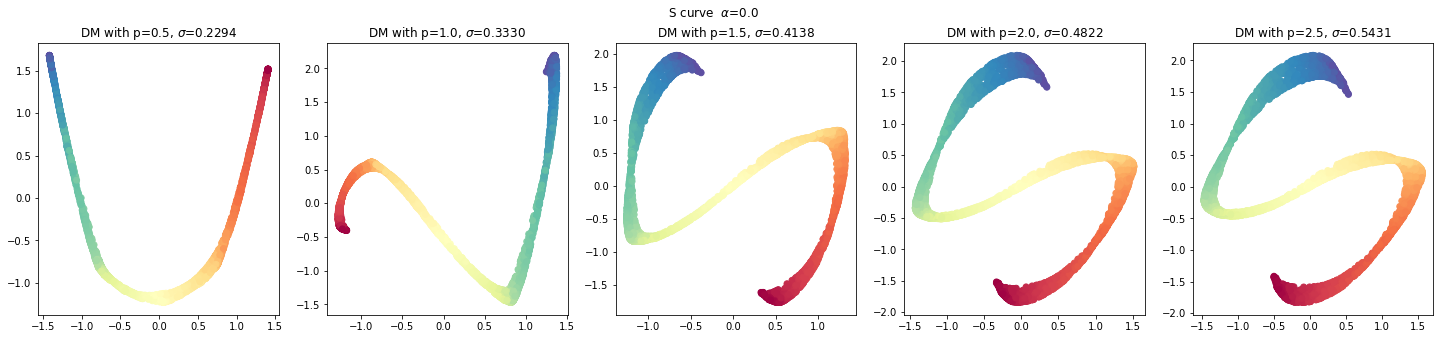

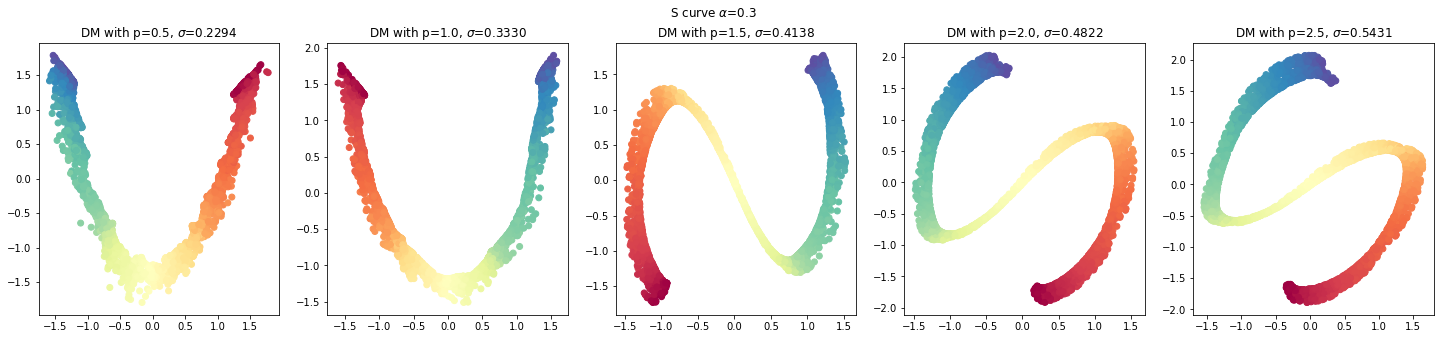

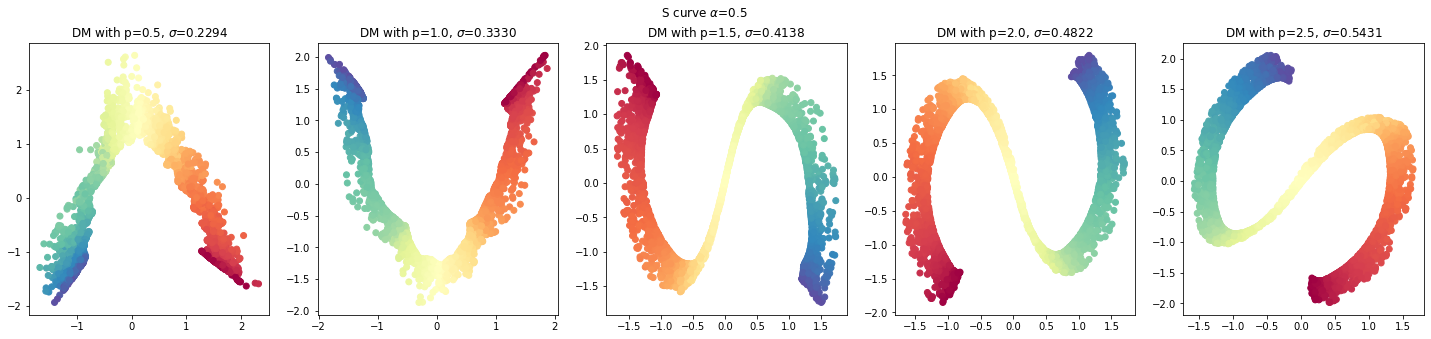

In [20]:
alpha_parameters = [0.0, 0.3, 0.5]
percentil_parameters = [0.5, 1.0, 1.5, 2.0, 2.5]

for alpha in alpha_parameters:
    dm_percentil = [
        DM(percentil=percentil, alpha=alpha, kernel_type="laplacian")
        for percentil in percentil_parameters
    ]

    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    fig.suptitle(r"S curve  $\alpha$={0}".format(alpha))
    for i, dm in enumerate(dm_percentil):
        X_red = dm.fit_transform(X)
        axes[i].scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
        axes[i].set_title(
            r"DM with p={0}, $\sigma$={1:.4f}".format(
                percentil_parameters[i], dm.sigma_
            )
        )

Al utilizar el núcleo laplaciano, no hemos encontrado una elección de parámetros adecuada que consiga desenrollar los datos en una banda como la obtenida para el núcleo gaussiano. Aún así, se obtienen buenas representaciones, sobre todo para $\sigma=0.330$ y $\alpha=0.5$.


Finalmente, representaremos el embedding para las dos mejores configuraciones de parámetros de ambos núcleos tanto para los datos embebidos como para nuevos datos utilizando la aproximación de Nystrom.

- {kernel RBF, $\alpha$=0.5, $\sigma$= 0.48 $\sim$ percentil=$2$}
- {kernel Laplaciano, $\alpha$=0.5, $\sigma$= 0.3330 $\sim$ percentil=$1$}

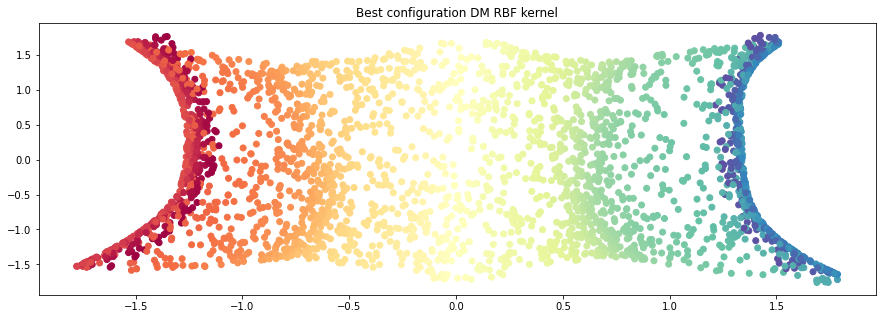

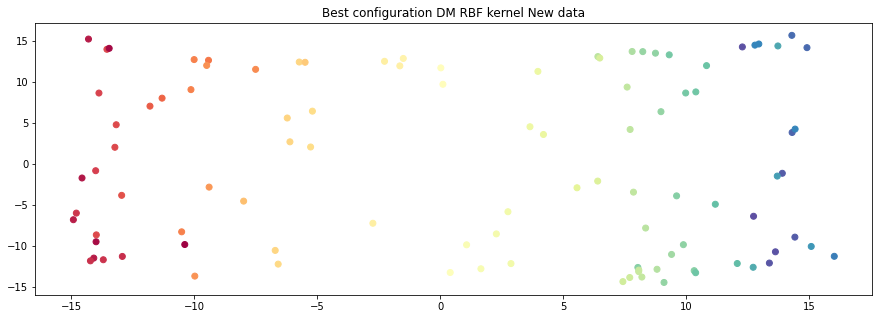

In [21]:
# RBF kernel
dm = DM(percentil=2, alpha=0.5)
X_red = dm.fit_transform(X)

plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.title("Best configuration DM RBF kernel")
plt.show()

X_red_new = dm.transform(X_new)

plt.scatter(X_red_new[:, 0], X_red_new[:, 1], c=color_new, cmap=my_cmap)
plt.title(r"Best configuration DM RBF kernel New data")
plt.show()

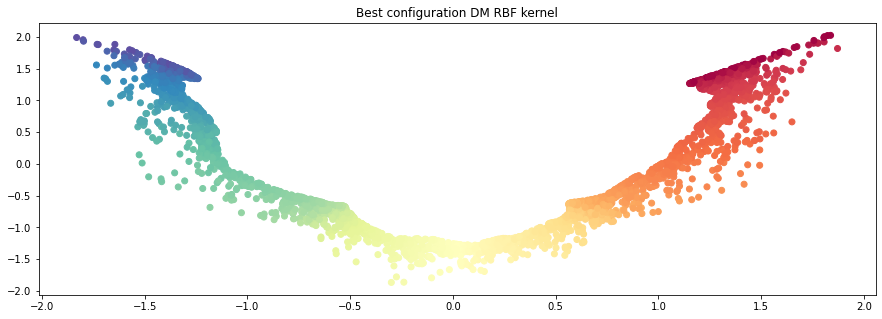

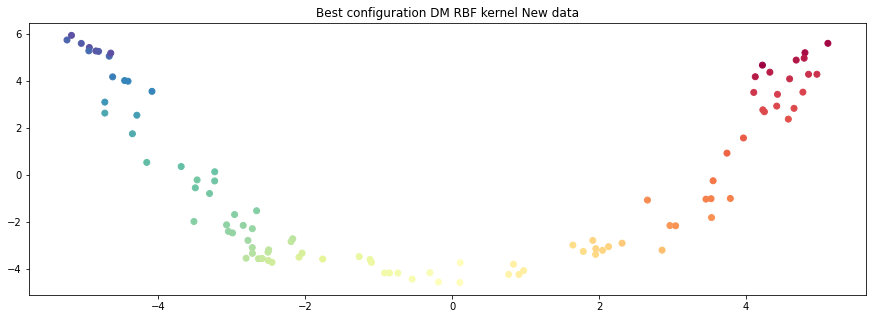

In [22]:
# Laplacian kernel
dm = DM(percentil=1, alpha=0.5, kernel_type="laplacian")
X_red = dm.fit_transform(X)

plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.title("Best configuration DM RBF kernel")
plt.show()

X_red_new = dm.transform(X_new)

plt.scatter(X_red_new[:, 0], X_red_new[:, 1], c=color_new, cmap=my_cmap)
plt.title(r"Best configuration DM RBF kernel New data")
plt.show()

Ambos consiguen una buena representación de los datos no observados, destacando la banda obtenida por el núcleo gaussiano.

<div class="qst">

1. Do you consider that the embedding obtained is good for the previous datasets? Is it the expected one? Why?
    
    
2. How sensible is the method to its hyper-parameters? Specify the best values that you have found and the technique employed for it.
    * Check how much influence the sample density (you can vary N for each dataset).
    * Check what happens if the number of steps `steps` grows.
   
    
3. In your opinion, which is the main advantage and disadvantage of this method?
    
</div>

**Answers**:

Para el primer conjunto de datos el embedding obtenido era correcto y esperado ya que las distancias entre clases en el embedding son mayores. Por otro lado, el embedding para datos no observados no es tan preciso y las clases no están tan separadas. Para el conjunto de datos del swiss roll, la mejor representación de los datos de entrenamiento se obtenía para 
* {kernel laplaciano, $\alpha=0.0$  $\sim$ percentil = $0.2$}, 

el cual obtenia una especie de proyección de los datos desenrollados. Sin embargo, vimos que no daba tan buenos resultados para datos no observados. Por eso concluimos que utilizar 

* {kernel RBF, $\alpha=0.5$ $\sim$ percentil = $0.5$} 

era más conveniente. Finalmente, para la curva 'S', encontramos una configuración de parámetro óptima 

* {kernel RBF, $\alpha$=0.5, $\sigma$= 0.48 $\sim$ percentil=$2$}, 

que conseguía desenrollar la 'S' y obtenía buenas representaciones para nuevos datos. 

Respecto a los parámetros de densidad $\alpha$ y número de pasos en el grafo $T$, a continuación se realiza el análisis para determinar como influyen en las representaciones de los dos últimos conjuntos.

La influencia de parámetro $\alpha$ permite controlar la influencia de la densidad de la muestra. Este control es importante ya que cuando el muestreo de la variedad no es uniforme y no se muestrea un número suficiente de datos, no tiene por qué conseguir un buen embedding de los datos. Cuando $\alpha=1$, Diffusion Maps captura la geometría subyacente sin interferir en la densidad de la muestra mientras que cuando $\alpha=0$, la influencia es muy fuerte a menos que la densidad sea uniforme. 

A continuación, se muestra un análisis de la influencia del parámetro de densidad $\alpha$ según variamos el número de datos de los dos conjuntos con geometrías complicadas utilizando en ambas el sigma elegido por el percentil 1.

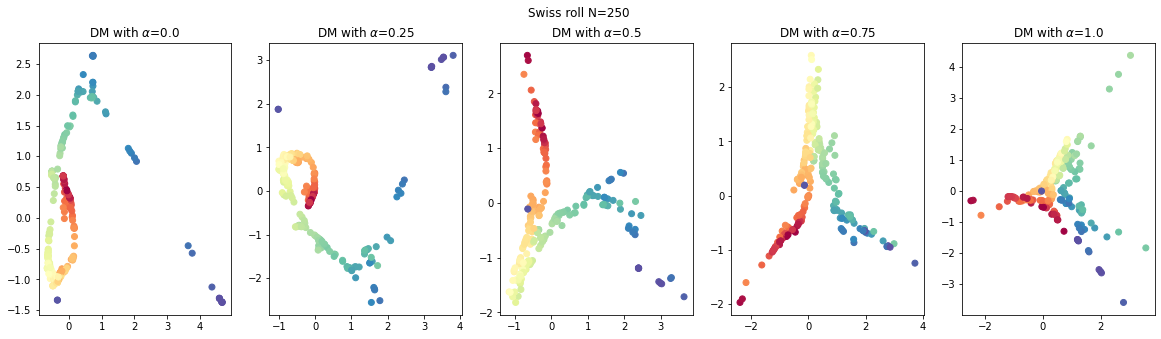

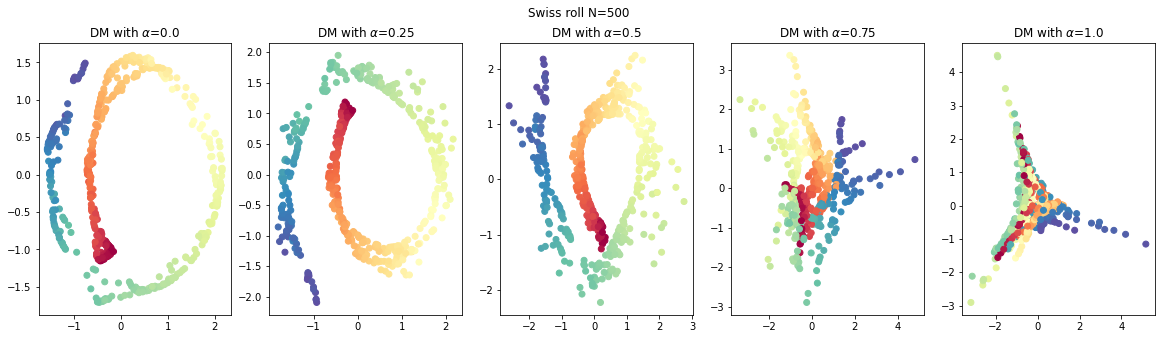

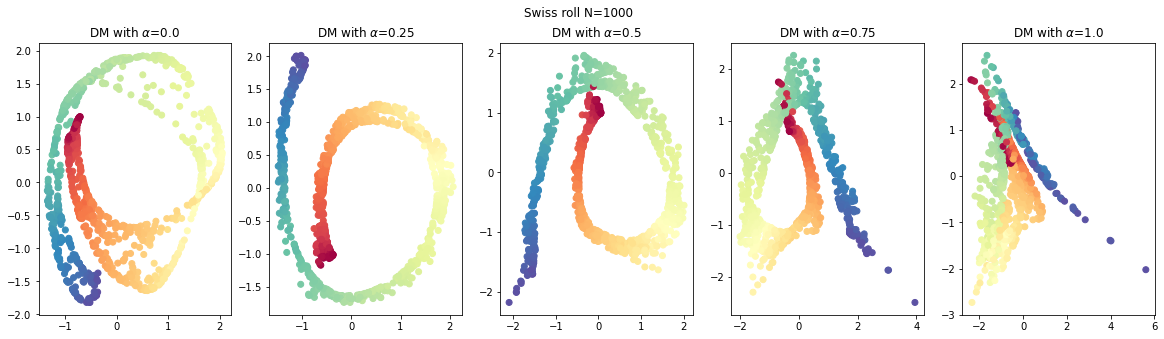

In [23]:
alpha_parameters = [0.0, 0.25, 0.5, 0.75, 1.0]
N = [250, 500, 1000]

# Swiss roll
for n in N:
    X, color = make_swiss_roll(n_samples=n, random_state=seed)
    X = scaler.fit_transform(X)
    dm_alpha = [DM(percentil=1.0, alpha=alpha) for alpha in alpha_parameters]
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle(f"Swiss roll N={n}")
    for i, dm in enumerate(dm_alpha):
        X_red = dm.fit_transform(X)
        axes[i].scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
        axes[i].set_title(r"DM with $\alpha$={0}".format(alpha_parameters[i]))

En la imagen anterior podemos observar que cuando no hay suficientes datos, no se obtiene ningún embedding bueno sea cual sea el valor de densidad. Cuando empiezan a aumentar los datos vemos que al utilizar $\alpha$ mayores se consiguen también buenas representaciones. 

Veamos que ocurre para el caso de la curva 'S'.

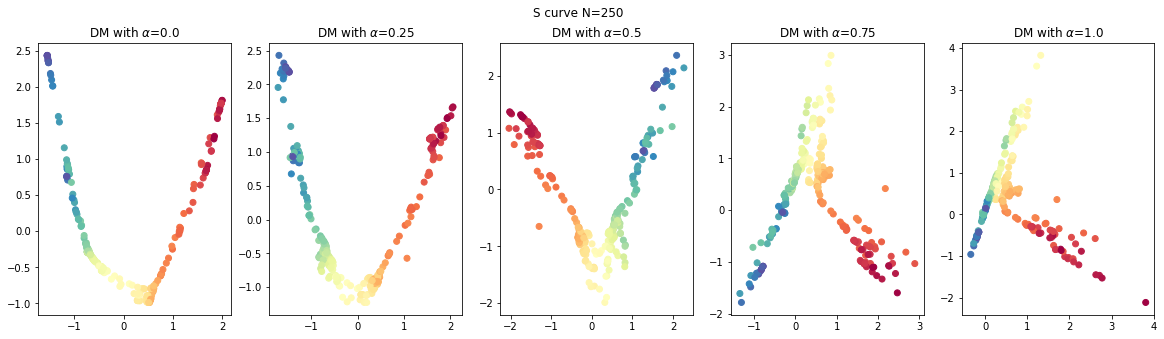

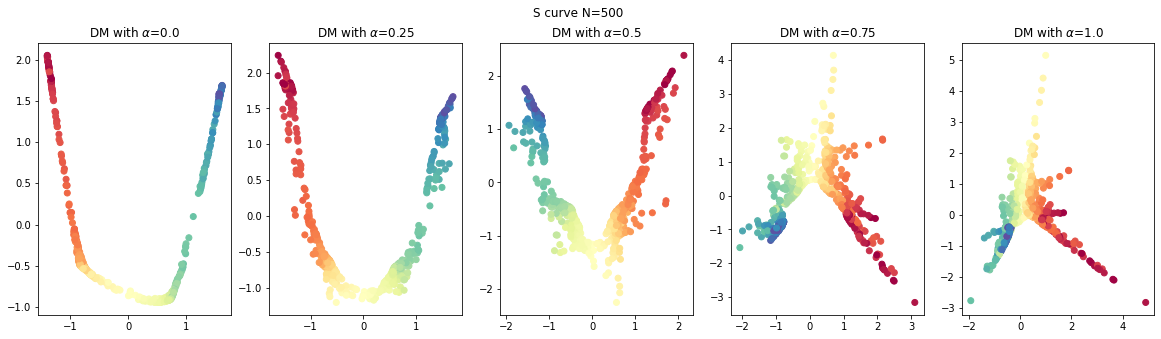

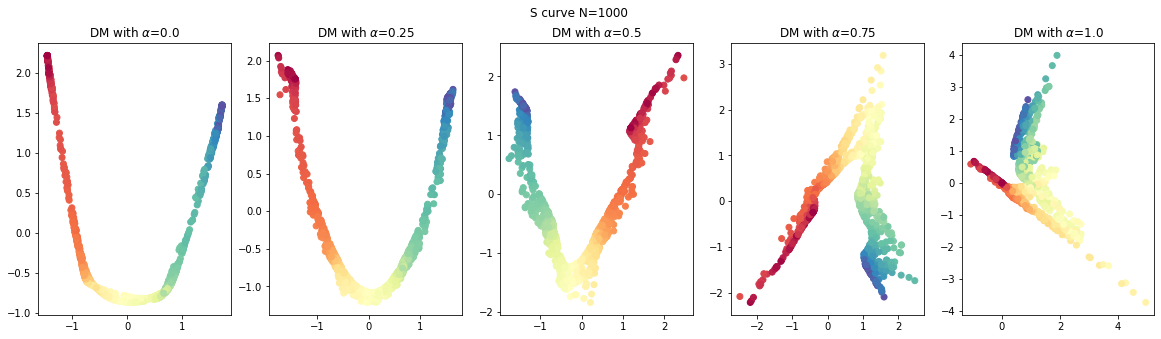

In [24]:
alpha_parameters = [0.0, 0.25, 0.5, 0.75, 1.0]
N = [250, 500, 1000]

# S curve
for n in N:
    X, color = make_s_curve(n, random_state=seed)
    X = scaler.fit_transform(X)
    dm_alpha = [DM(percentil=1.0, alpha=alpha) for alpha in alpha_parameters]
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle(f"S curve N={n}")
    for i, dm in enumerate(dm_alpha):
        X_red = dm.fit_transform(X)
        axes[i].scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
        axes[i].set_title(r"DM with $\alpha$={0}".format(alpha_parameters[i]))

En esta ocasión, con pocos datos se consiguen buenas representaciones, de modo que no se obtienen resultados tan catastróficos cuando aumentar el parámetro $\alpha$. 

Finalmente analizaremos la influencia del parámetro $T$. El parámetro $T$ es el número de pasos en el grafo de difusión, y controla la cantidad de componentes relevantes en el embedding: 

$$X_{red} = \lambda^{T}\psi.$$

Es decir, a medida que aumenta $T$, la diferencia entre los autovalores aumenta, de manera que las últimas componentes son cada vez más insignificantes. 

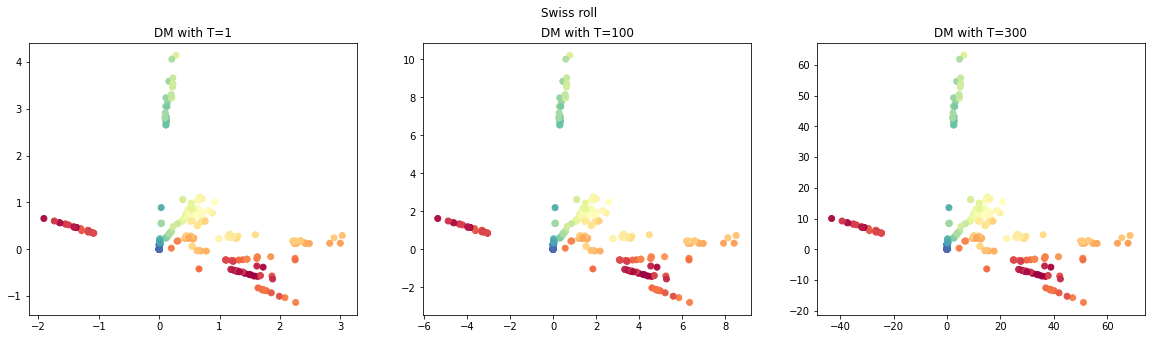

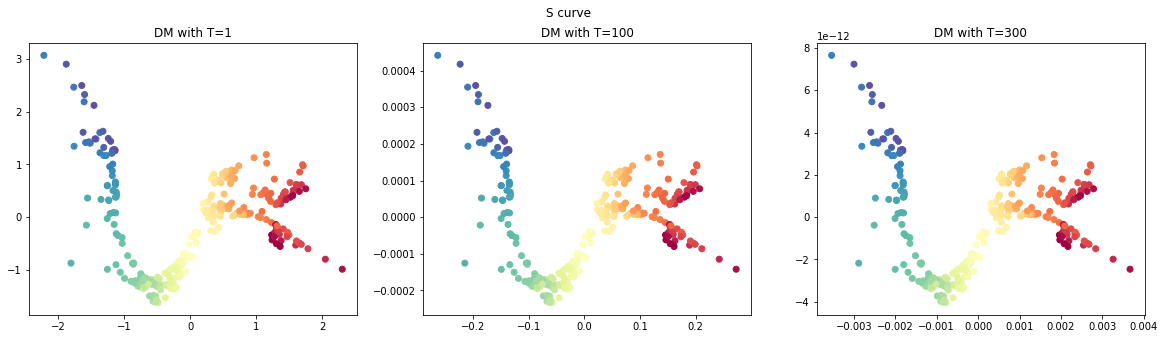

In [25]:
# Swiss roll
N = 300
X, color = make_swiss_roll(n_samples=N, random_state=seed)
X = scaler.fit_transform(X)

step_parameters = [1, 100, 300]

dm_step = [DM(percentil=0.5, step=step, alpha=0.5) for step in step_parameters]
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("Swiss roll")
for i, dm in enumerate(dm_step):
    X_red = dm.fit_transform(X)
    axes[i].scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
    axes[i].set_title(f"DM with T={step_parameters[i]}")

# S curve
N = 300
X, color = make_s_curve(N, random_state=seed)
X = scaler.fit_transform(X)

step_parameters = [1, 100, 300]

dm_step = [DM(percentil=2, alpha=0.5, step=step) for step in step_parameters]
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("S curve")
for i, dm in enumerate(dm_step):
    X_red = dm.fit_transform(X)
    axes[i].scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
    axes[i].set_title(f"DM with T={step_parameters[i]}")

Si observamos las imágenes de arriba, vemos que la estructura geométrica del embedding se mentiene y que solo difieren en la escala, siendo cada vez menor. Además, para notar esta diferecia significativa en el escalado para los dos últimos conjuntos es necesario aumentar el número de pasos en el proceso de Markov.

**Conclusiones**

En nuestra opinión, la principal ventaja de este método es que se modela utilizando procesos de Markov, lo que permite otorgar una estructura temporal a los datos. Además, el parámetro de difusión permite controlar la influencia de la densidad de las muestras, lo que hace el método más versatil. También presenta todos las ventajas de los algoritmos basados en variedades, que permiten reducir la dimensión de los datos utilizando transformaciones no lineales al asumir que estos viven en variedades en las que se preservan las distancias. Como principal inconveniente, ambos miembros de la pareja coincidimos que es el alto coste computacional que supone tanto volver a computar la matriz de afinidad para datos no observados utilizando la aproximación de Nystrom como en la búsqueda de hiperparámetros.